In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mpbn
import boolsim
from colomoto.minibn import BooleanNetwork
import pystablemotifs as sm

In [32]:
file = '../../model/bcrn_to_maboss/basemodel/basemodel.bnet'
primes = sm.format.import_primes(file)
sm.format.pretty_print_prime_rules(primes)

AMPK* = !ULK1 & !mTOR
ULK1* = AMPK & !mTOR
mTOR* = !AMPK & !ULK1


In [33]:
ar = sm.AttractorRepertoire.from_primes(primes)

In [34]:
frames = []
for idx, attractor in enumerate(ar.attractors):
    row = {
        node: (
            next(iter(vals))
            if isinstance(vals, (set, tuple)) and len(vals) == 1
            else sorted(vals) if isinstance(vals, (set, tuple))
            else vals
        )
        for node, vals in attractor.attractor_dict.items()
    }
    frames.append(pd.DataFrame([row], index=[f"attractor_{idx}"]))

attractor_df = pd.concat(frames, axis=0)

# Compute Attractor States

In [35]:
attractor_df_adjusted = attractor_df.replace({False: 0, True: 1, 'X': 2})

In [36]:
attractor_df_adjusted

,AMPK,ULK1,mTOR
attractor_0,0,0,1


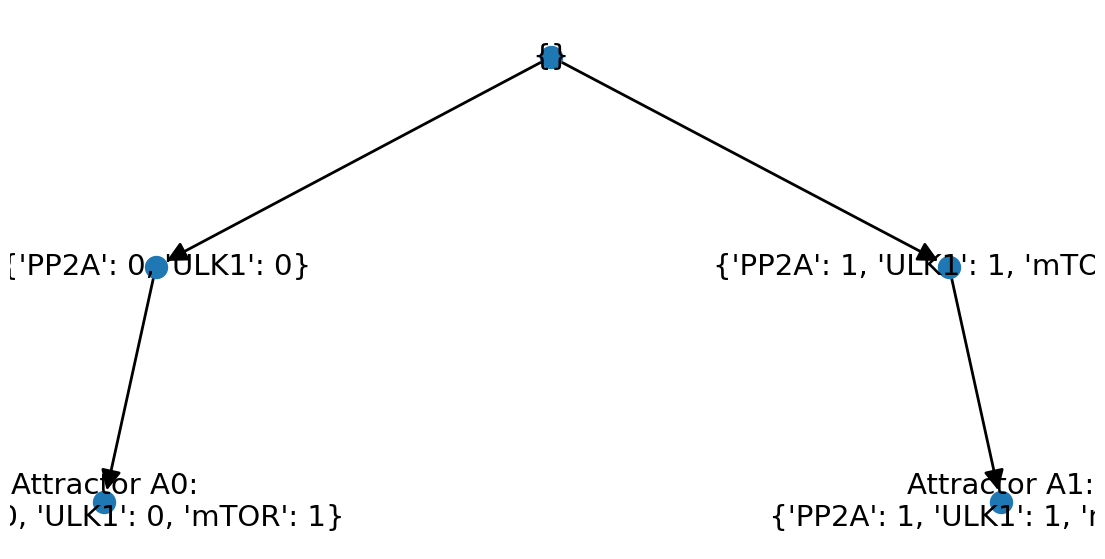

In [9]:
GR = sm.export.networkx_succession_diagram(ar, include_attractors_in_diagram=True)
sm.export.plot_nx_succession_diagram(GR,nx_node_label_kwargs={'font_size':21})

In [10]:
GR.nodes(data = True)

NodeDataView({0: {'index': 0, 'states': {}, 'history': [[]], 'motif union': {}, 'label': '{}'}, 1: {'index': 1, 'states': {'PP2A': 0, 'ULK1': 0, 'mTOR': 1}, 'history': [[{'PP2A': 0, 'ULK1': 0}]], 'motif union': {'PP2A': 0, 'ULK1': 0}, 'label': "{'PP2A': 0, 'ULK1': 0}"}, 2: {'index': 2, 'states': {'PP2A': 1, 'ULK1': 1, 'mTOR': 0}, 'history': [[{'PP2A': 1, 'ULK1': 1, 'mTOR': 0}]], 'motif union': {'PP2A': 1, 'ULK1': 1, 'mTOR': 0}, 'label': "{'PP2A': 1, 'ULK1': 1, 'mTOR': 0}"}, 'A0': {'index': 'A0', 'states': {'PP2A': 0, 'ULK1': 0, 'mTOR': 1}, 'label': "Attractor A0:\n {'PP2A': 0, 'ULK1': 0, 'mTOR': 1}"}, 'A1': {'index': 'A1', 'states': {'PP2A': 1, 'ULK1': 1, 'mTOR': 0}, 'label': "Attractor A1:\n {'PP2A': 1, 'ULK1': 1, 'mTOR': 0}"}})

In [11]:
import networkx as nx

# Create a mapping from old node labels to new labels (1-441)
mapping = {old_label: new_label for new_label, old_label in enumerate(GR.nodes(), start=0)}

# Relabel the nodes
G = nx.relabel_nodes(GR, mapping)

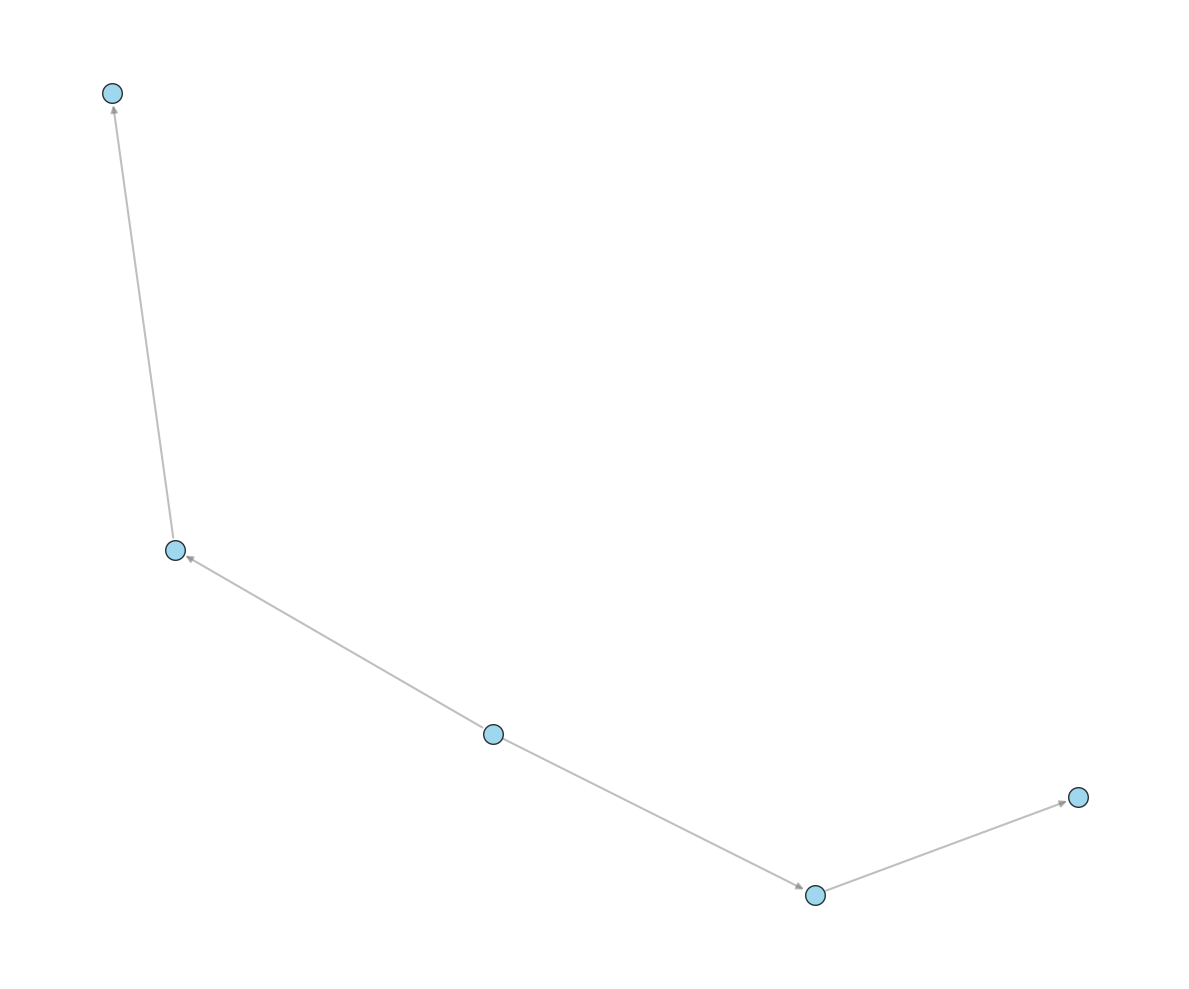

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Choose a different layout algorithm
pos = nx.spring_layout(GR, k=0.5, iterations=50)  # or try: kamada_kawai_layout, circular_layout, spectral_layout

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(GR, pos, node_size=200, node_color='skyblue', 
                       alpha=0.8, edgecolors='black', linewidths=1)
nx.draw_networkx_edges(GR, pos, edge_color='gray', alpha=0.5, 
                       arrows=True, arrowsize=10, width=1.5)

plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
import pystablemotifs as sm
import pyboolnet
import pystablemotifs.export as ex
import networkx as nx

In [14]:
for a in ar.attractors:
    if a.n_unfixed == 0: continue # skip steady states
    print(a.attractor_dict)
    nx.draw(a.stg,with_labels=True)
    plt.show()

In [16]:
import sys
sys.path.append('../../')
from maboss_visualize import *


# Setup the model name and the network path
model_folder = "../../model/bcrn_to_maboss/basemodel/" 
network_path = model_folder + 'basemodel' + '.xgmml'

# Load the network into the maboss_visualizer tool
network = Net_visualizer()
network.load_network_xgmml(network_path)

Network loaded : ../../model/bcrn_to_maboss/basemodel/basemodel.xgmml


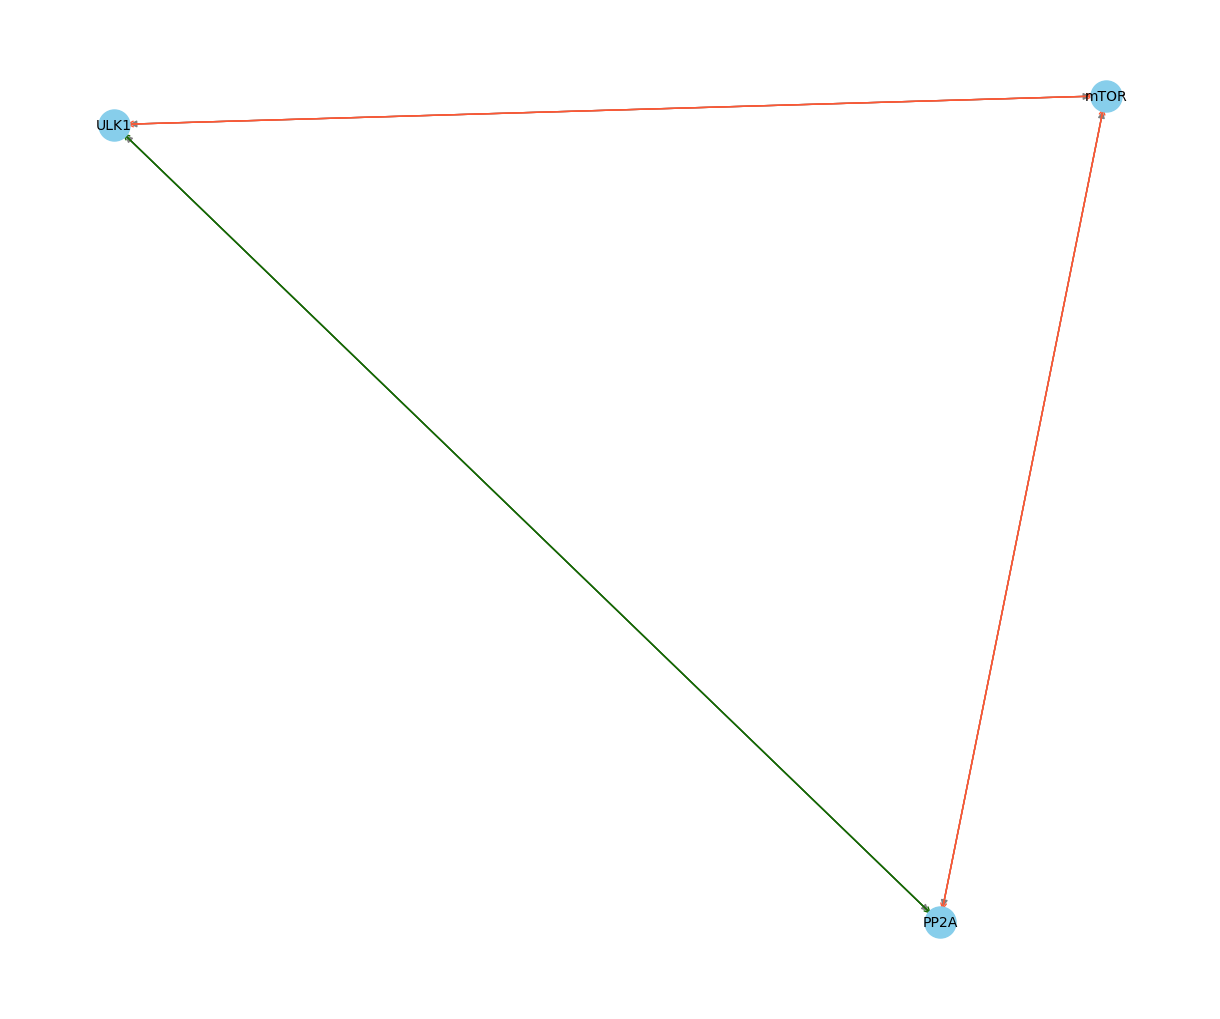

In [17]:
network.plot_network()

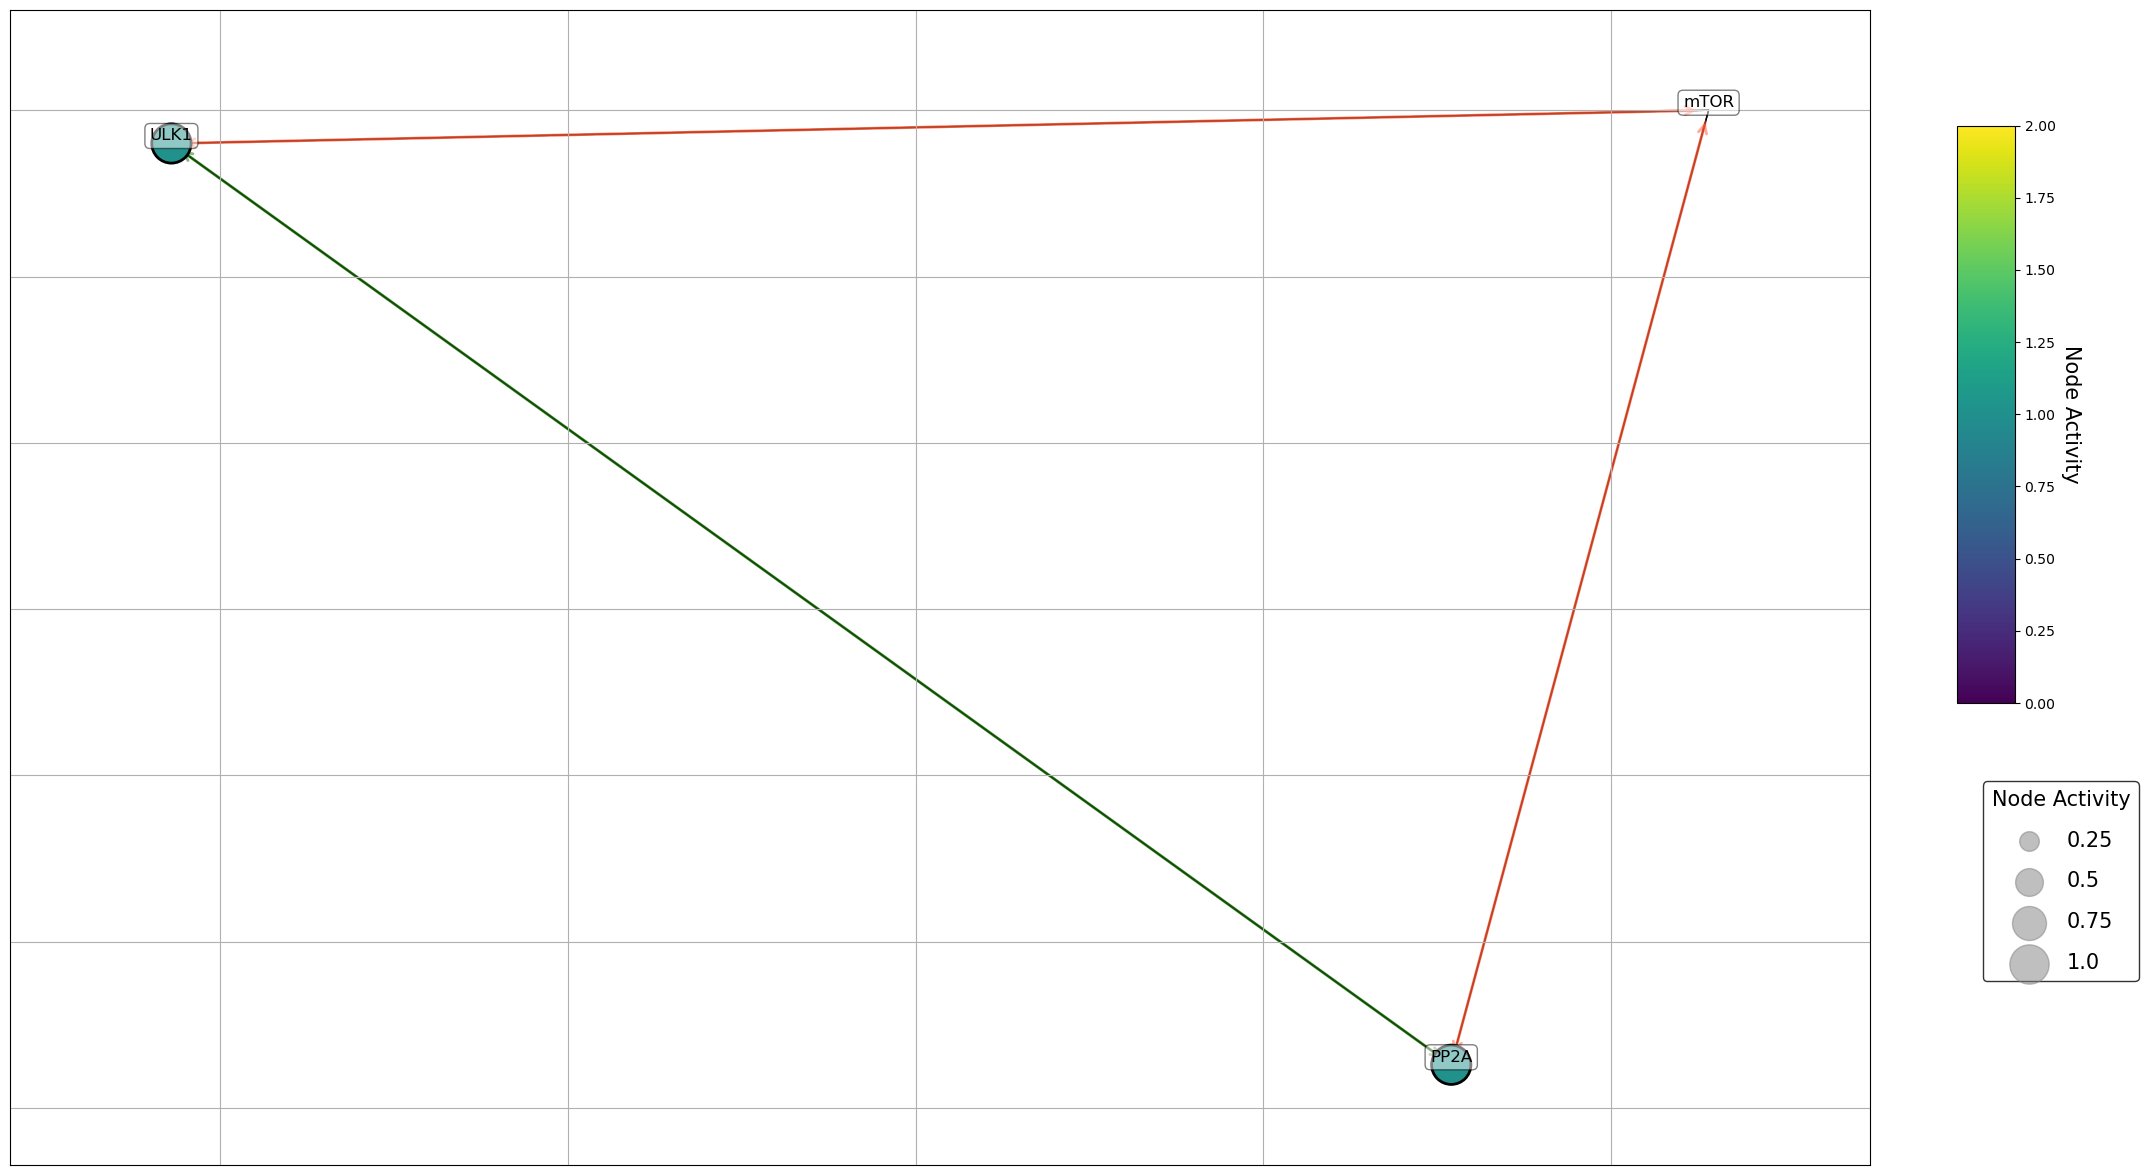

In [19]:
# Declare the parameters for the network plot
timepoint = 0
node_size = 800
figure_size = (30,15)
max_activity = 2
min_activity = 0

# Load dataset
G = network.network
pos = network.position
edge_colors = network.edge_colors
nodesize = node_size

# Get the different matrix activity
diff_mtx = attractor_df_adjusted.loc['attractor_1']

# Ensure the node_size array has the same length as the number of nodes in the graph
node_sizes = nodesize * np.array([diff_mtx.get(node, 0) for node in G.nodes])

# Normalize the node values for color mapping
norm = plt.Normalize(vmin = min_activity, vmax = max_activity)
node_colors = cm.viridis(norm([diff_mtx.get(node, 0) for node in G.nodes]))

# Plot the network using the positions and 'name' as node identifiers
plt.figure(figsize=figure_size)
options = {
    "node_size": node_sizes,
    "node_color": node_colors,
    "edgecolors": "black",
    "linewidths": 2,
    'arrowstyle':'-'
}
nx.draw_networkx(G, pos, **options, with_labels=False)
nx.draw_networkx_labels(G, pos, 
                        font_size=12, font_family='sans-serif',
                        clip_on=False,
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha = .5),
                        #bbox_to_anchor=(0.5, 0.5),
                        verticalalignment='bottom')
nx.draw_networkx_edges(G,pos,
                    arrows = True,
                    arrowstyle="->",
                    arrowsize=15, 
                    alpha = .5,
                    edge_color=edge_colors, width=2)

# Create legend for node sizes
sizes = [nodesize*1/4, nodesize*1/2, nodesize*3/4, nodesize]
for size in sizes:
    plt.scatter([], [], s=size, c='gray', alpha=0.5, label=str(size/800))

# Create a colorbar for the node activity
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.viridis), ax=plt.gca(), shrink=0.5, aspect=10, anchor=(-0.1, 0.8), location='right')
cbar.set_label('Node Activity', rotation=270, labelpad=18, fontsize = 15)

plt.legend(scatterpoints=1, 
        frameon=True, labelspacing=1, 
        title='Node Activity', loc='lower right', edgecolor='black', bbox_to_anchor=(1.15, 0.15), fontsize=15, title_fontsize=15, ncol=1)

plt.grid()
plt.show()

# Canalization

In [46]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import graphviz
import math
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Cana
import cana
from cana.boolean_network import BooleanNetwork
# Networkx
import networkx as nx

In [47]:
file = '../model/bcrn_to_maboss/test_net_v2.txt'
T = BooleanNetwork.from_file(file,type="logical", name="bcrn_to_maboss",keep_constants=True)

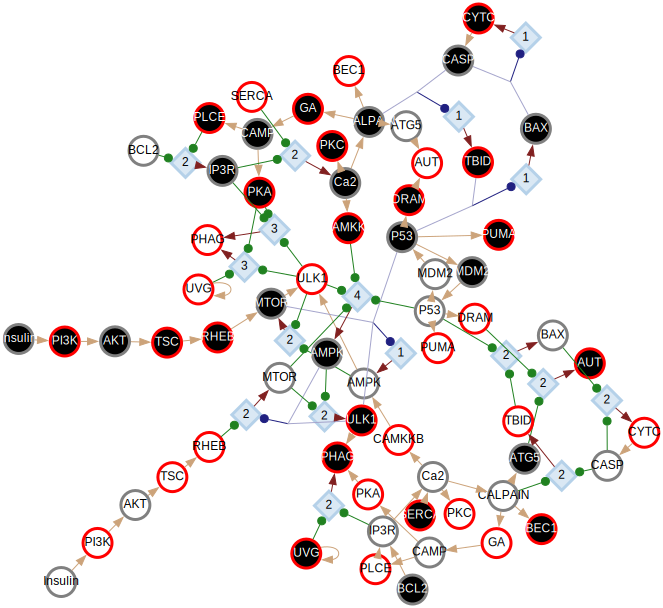

In [48]:
import cana
import pandas as pd
import graphviz
import math
from collections import Counter, defaultdict
import numpy as np
from cana.boolean_network import BooleanNetwork
# Networkx
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
from cana.drawing.canalizing_map import draw_canalizing_map_graphviz

DCM = T.dynamics_canalization_map(simplify=True)
# Draws using the graphviz interface.
gDCM = draw_canalizing_map_graphviz(DCM)
# Display
display(gDCM)

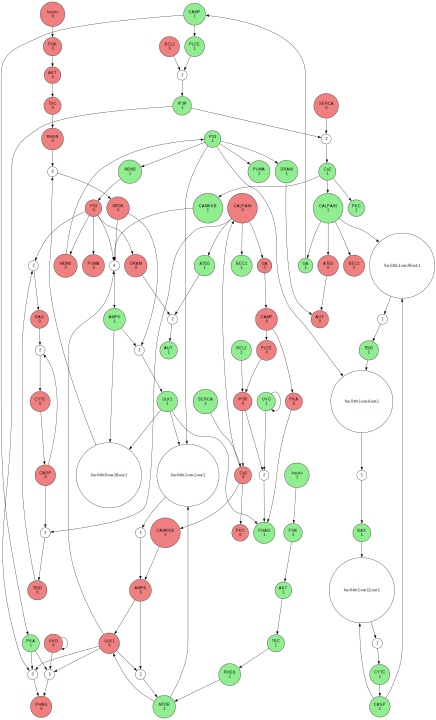

In [49]:
import graphviz

def draw_hierarchical_dcm(dcm, figsize=(20, 10), rankdir='TB'):
    """
    Draw the DCM (Dynamics Canalization Map) using a hierarchical layout.
    
    Parameters:
    -----------
    dcm : networkx.DiGraph
        The dynamics canalization map
    figsize : tuple
        Figure size (width, height) in inches
    rankdir : str
        Direction of graph layout: 'TB' (top-bottom), 'LR' (left-right), 
        'BT' (bottom-top), 'RL' (right-left)
    
    Returns:
    --------
    graphviz.Digraph : The hierarchical DCM visualization
    """
    # Create a new Digraph with hierarchical layout engine
    dot = graphviz.Digraph(engine='dot')
    dot.attr(rankdir=rankdir)
    dot.attr(size=f'{figsize[0]},{figsize[1]}')
    dot.attr('node', shape='circle', style='filled', fontname='Helvetica')
    dot.attr('edge', arrowhead='normal')
    
    # Add nodes with their attributes
    for node_id, node_data in dcm.nodes(data=True):
        label = node_data.get('label', str(node_id))
        value = node_data.get('value', '')
        node_type = node_data.get('type', '')
        
        # Customize node appearance based on type and value
        if node_type == 'variable':
            if value == 1:
                fillcolor = 'lightgreen'
            elif value == 0:
                fillcolor = 'lightcoral'
            else:
                fillcolor = 'lightblue'
        else:
            fillcolor = 'white'
        
        display_label = f"{label}\n{value}" if value != '' else label
        dot.node(str(node_id), label=display_label, fillcolor=fillcolor)
    
    # Add edges
    for source, target, edge_data in dcm.edges(data=True):
        dot.edge(str(source), str(target))
    
    return dot

# Apply the function to DCM
hierarchical_dcm = draw_hierarchical_dcm(DCM, figsize=(20, 10), rankdir='TB')
display(hierarchical_dcm)

In [50]:
def find_variable_by_label(dcm, label, value):
    """
    Search for nodes in DCM with matching label and value.
    
    Parameters:
    -----------
    dcm : networkx.DiGraph
        The dynamics canalization map
    label : str
        The variable label to search for
    value : int
        The output value (0 or 1)
    
    Returns:
    --------
    list : List of matching node IDs
    """
    matching_nodes = []
    for node_id, node_data in dcm.nodes(data=True):
        if node_data.get('label') == label and node_data.get('value') == value:
            matching_nodes.append(node_id)
    return matching_nodes

# Example usage:
# nodes = find_variable_by_label(DCM, 'Proliferation', 1)
# print(nodes)

In [51]:
def draw_canalization_map_by_name(network, node_name):
    """
    Draw the canalization map for a specific node by its name.
    
    Parameters:
    -----------
    network : BooleanNetwork
        The Boolean network object
    node_name : str
        The name of the node to visualize
    
    Returns:
    --------
    graphviz object : The canalization map visualization
    """
    # Find the node index by name
    node_names = [node.name for node in network.nodes]
    
    if node_name not in node_names:
        raise ValueError(f"Node '{node_name}' not found. Available nodes: {node_names}")
    
    node_idx = node_names.index(node_name)
    
    # Get the canalization map for the node
    CM = network.nodes[node_idx].canalizing_map()
    
    # Draw using the graphviz interface
    gCM = draw_canalizing_map_graphviz(CM)
    
    return gCM

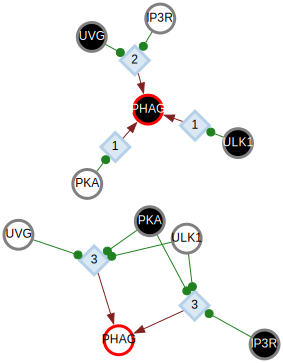

In [52]:
draw_canalization_map_by_name(T, 'PHAG')

In [ ]:
def trace_upstream_regulators(dcm, node_name, value):
    """
    Trace all upstream regulators from a specific node and value in the DCM.
    
    Parameters:
    -----------
    dcm : networkx.DiGraph
        The dynamics canalization map
    node_name : str
        The name of the target node
    value : int
        The output value (0 or 1)
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'target_nodes': list of target node IDs matching the name and value
        - 'all_upstream': set of all upstream node IDs
        - 'upstream_by_target': dict mapping each target to its upstream nodes
        - 'upstream_labels': dict mapping node IDs to their labels
    """
    # Find target nodes with matching label and value
    target_nodes = find_variable_by_label(dcm, node_name, value)
    
    if not target_nodes:
        return {
            'target_nodes': [],
            'all_upstream': set(),
            'upstream_by_target': {},
            'upstream_labels': {}
        }
    
    # Collect all upstream nodes
    all_upstream = set()
    upstream_by_target = {}
    
    for target in target_nodes:
        # Use BFS or DFS to find all predecessors
        visited = set()
        queue = [target]
        upstream_nodes = set()
        
        while queue:
            current = queue.pop(0)
            if current in visited:
                continue
            visited.add(current)
            
            # Get predecessors (upstream regulators)
            predecessors = list(dcm.predecessors(current))
            for pred in predecessors:
                if pred not in visited:
                    upstream_nodes.add(pred)
                    queue.append(pred)Proliferation
        
        upstream_by_target[target] = upstream_nodes
        all_upstream.update(upstream_nodes)
    
    # Create mapping of node IDs to their labels
    upstream_labels = {}
    for node_id in all_upstream:
        node_data = dcm.nodes[node_id]
        label = node_data.get('label', 'Unknown')
        value = node_data.get('value', 'Unknown')
        upstream_labels[node_id] = f"{label}={value}"
    
    return {
        'target_nodes': target_nodes,
        'all_upstream': all_upstream,
        'upstream_by_target': upstream_by_target,
        'upstream_labels': upstream_labels
    }

# Example usage:
result = trace_upstream_regulators(DCM, 'Proliferation', 1)
# print(f"Target nodes: {result['target_nodes']}")
# print(f"Total upstream regulators: {len(result['all_upstream'])}")
# print(f"Upstream labels: {result['upstream_labels']}")

In [54]:
def extract_upstream_subgraph(dcm, node_name, value):
    """
    Extract a subgraph containing a target node and all its upstream regulators.
    
    Parameters:
    -----------
    dcm : networkx.DiGraph
        The dynamics canalization map
    node_name : str
        The name of the target node
    value : int
        The output value (0 or 1)
    
    Returns:
    --------
    tuple : (subgraph, result_dict)
        - subgraph: NetworkX DiGraph containing target and upstream nodes
        - result_dict: Dictionary from trace_upstream_regulators with node info
    """
    # Get upstream regulators
    result = trace_upstream_regulators(dcm, node_name, value)
    
    if not result['target_nodes']:
        print(f"No nodes found for {node_name}={value}")
        return None, result
    
    # Combine target nodes and all upstream regulators
    all_nodes = set(result['target_nodes']) | result['all_upstream']
    
    # Extract subgraph
    subgraph = dcm.subgraph(all_nodes).copy()
    
    print(f"Subgraph created with {len(subgraph.nodes())} nodes and {len(subgraph.edges())} edges")
    print(f"Target nodes: {len(result['target_nodes'])}")
    print(f"Upstream regulators: {len(result['all_upstream'])}")
    
    return subgraph, result



Subgraph created with 51 nodes and 64 edges
Target nodes: 1
Upstream regulators: 50


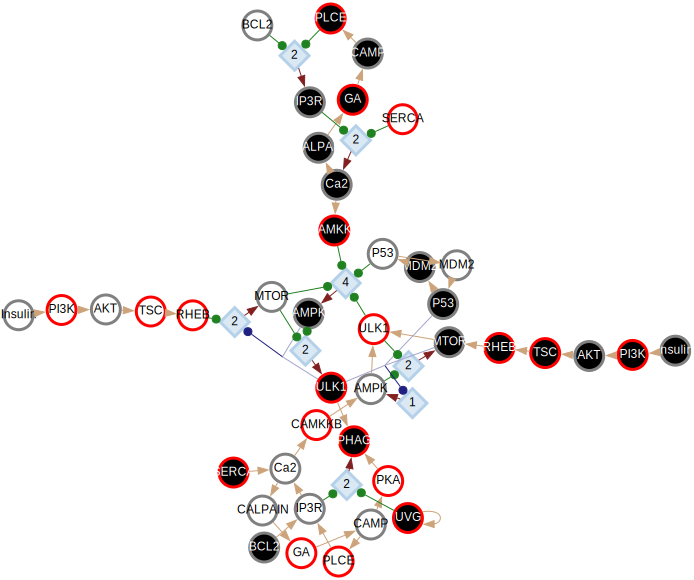

In [55]:
# Example usage:
subgraph, result = extract_upstream_subgraph(DCM, 'PHAG', 1)
gCM = draw_canalizing_map_graphviz(subgraph)
# Display
display(gCM)

In [10]:
import xml.etree.ElementTree as ET

# Initialize an empty directed graph
G = nx.DiGraph()
network_path = '../boolean/Autophagy_and_apoptosis.xgmml'

# Parse the XGMML file
tree = ET.parse(network_path)
root = tree.getroot()

# Namespace dictionary (if needed)
ns = {'xgmml': 'http://www.cs.rpi.edu/XGMML'}

# Iterate through all nodes in the XGMML
for node in root.findall('.//xgmml:node', ns):
    node_label = node.get('label')

    # Use the label as the node ID
    G.add_node(node_label, label=node_label)
    
    # Add any custom attributes
    for att in node.findall('xgmml:att', ns):
        att_name = att.get('name')
        att_value = att.get('value')
        G.nodes[node_label][att_name] = att_value
        
    # Parse the node position (x, y, z) from the graphics element
    graphics = node.find('xgmml:graphics', ns)
    if graphics is not None:
        x = float(graphics.get('x', 0.0))
        y = float(graphics.get('y', 0.0))
        z = float(graphics.get('z', 0.0))  # Optional, default to 0.0 if not present
        G.nodes[node_label]['pos'] = (x, y, z)

pos = {node: (data['pos'][0], -data['pos'][1]) for node, data in G.nodes(data=True)}

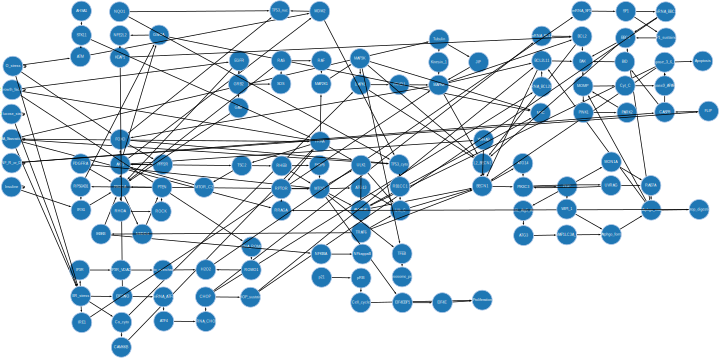

In [14]:
pSG = graphviz.Digraph(name='Interaction Graph', engine='neato')
pSG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='scale',splines='false',ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='1.5', color='#aec7e8', style='filled', fillcolor='#1f77b4', penwidth='4', fontname='Helvetica', fontcolor='white',fontsize='20')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

for nid,d in SG.nodes(data=True):
    nid = str(nid)
    label = d['label']
    pos_graph = str(pos[label][0]/100) + ',' + str(pos[label][1]/100) 
    #fillcolor = 'white'
    pSG.node(nid, label=label, pos = pos_graph)

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    pSG.edge(uid, vid, weight=weight)
    
# Export
display(pSG)
#pSG.render("Thaliana-IG", cleanup=True)

In [15]:
pEG = graphviz.Digraph(name='Effective Graph', engine='neato')
pEG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='false',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='1.5', color='#ff9896', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='20')
pEG.attr('edge', arrowhead='normal', arrowsize='1', color='black', penwidth='4')

max_outdegree = max([v for n,v in EG0.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG0.nodes(data=True)]

min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
cmap = LinearSegmentedColormap.from_list('custom', ['white','#d62728'])
cmap.set_under('#2ca02c')
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=10**-16, vmax=max_outdegree)
# Plot Colorbar
fig = plt.figure(figsize=(.75,1.5))
ax = fig.add_axes([0.1, 0.05, 0.21, 0.9])
ticks = [0,2,4,6,8]
boundaries = np.linspace(-1, max_outdegree,25).tolist()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=boundaries,
                               ticks=ticks,spacing='uniform', orientation='vertical',
                               extend='min', format='%.0f')
cb.set_label('Effective out-degree')

display(fig)
#plt.savefig('colorbar.pdf', transparent=True)
plt.close()
#
for nid,d in EG.nodes(data=True):
    dEG0 = EG0.nodes[nid]
    snid = str(nid)
    label = d['label']
    pos_graph = str(pos[label][0]/100) + ',' + str(pos[label][1]/100)
    out_degree = EG0.out_degree(nid, weight='weight')
    if out_degree == 0:
        color = '#98df8a'
        fillcolor = '#2ca02c'
    else:
        rgb = cmap(norm(EG0.out_degree(nid, weight='weigth')))
        hex = mpl.colors.rgb2hex(rgb)
        color = '#ff9896'
        fillcolor = hex
    pEG.node(snid, label=label, color=color, fillcolor=fillcolor, pos = pos_graph)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight'] * max_penwidth )
    if d['weight'] > 0:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        pEG.edge(uid,vid, style='dashed', color='#d62728')
    
# Export
display(pEG)
#pEG.render("Thaliana-EG", cleanup=True)

KeyError: 'effective_connectivity'

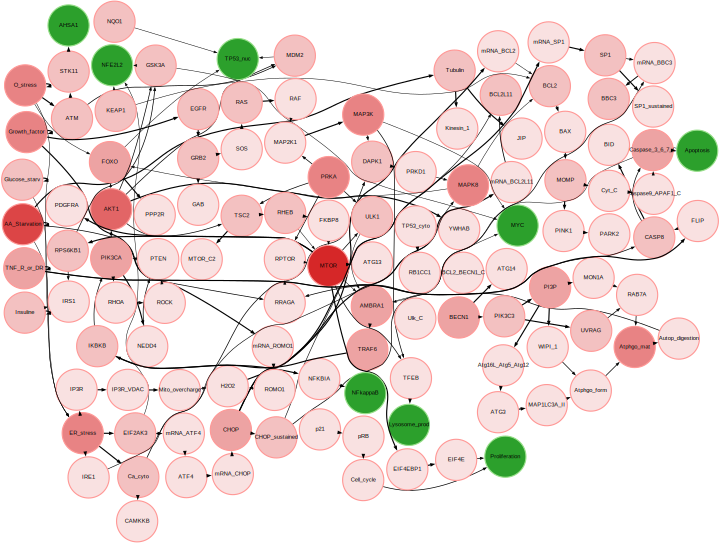

In [88]:
pEG = graphviz.Digraph(name='Effective Graph', engine='neato')
pEG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='2', color='#ff9896', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='20')
pEG.attr('edge', arrowhead='normal', arrowsize='1', color='black', penwidth='10')


# Plot Graph
for nid,d in EG.nodes(data=True):
    snid = str(nid)
    label = d['label']
    pos_graph = str(pos[label][0]/100) + ',' + str(pos[label][1]/100)
    out_degree = EG0p4.out_degree(nid, weight='weight')
    if out_degree == 0:
        color='#98df8a'
        fillcolor = '#2ca02c'
    else:
        rgb = cmap(norm(EG0p4.out_degree(nid, weight='weigth')))
        hex = mpl.colors.rgb2hex(rgb)
        color = '#ff9896'
        fillcolor = hex
    pEG.node(snid, label=label, color=color, fillcolor=fillcolor, pos = pos_graph)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight'] * max_penwidth )
    if d['weight'] >= 0.4:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        #pEG.edge(uid,vid, style='dashed', color='#d62728')
        pass

# Export
display(pEG)
#pEG.render("Thaliana-EGt0p4", cleanup=True)

In [13]:
SG = T.structural_graph()
EG = T.effective_graph(threshold=-1)
#
EG0 = T.effective_graph(threshold=0)
EG0p2 = T.effective_graph(threshold=.2)
EG0p4 = T.effective_graph(threshold=.4)

In [16]:
def number_of_input_nodes(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [] or inputs == [True]:
            count += 1
    return count
#
def number_of_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if any(inputs):
            count += 1
    return count
#
def number_of_input_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [True]:
            count += 1
    return count

In [17]:
EG.out_degree(weight= 'weight')

OutDegreeView({0: 3.635416666666667, 1: 0, 2: 3.291666666666667, 3: 1.5662202380952381, 4: 1.0, 5: 0.296875, 6: 0.375, 7: 1.0, 8: 1.625, 9: 0, 10: 1.0, 11: 0.625, 12: 1.9895833333333335, 13: 0.625, 14: 0.8125, 15: 0.4192708333333336, 16: 1.0859375, 17: 0.38913690476190477, 18: 0.1495535714285714, 19: 1.9921875, 20: 0.23958333333333337, 21: 0.2968750000000001, 22: 1.625, 23: 3.0, 24: 1.1354166666666667, 25: 1.625, 26: 0.625, 27: 1.5662202380952381, 28: 0.625, 29: 1.0, 30: 1.1796875000000002, 31: 1.0666666666666664, 32: 1.4166666666666667, 33: 0.625, 34: 1.0, 35: 4.0, 36: 0.41666666666666674, 37: 0.625, 38: 1.7135416666666667, 39: 0.06666666666666654, 40: 2.0, 41: 0.8333333333333335, 42: 1.4166666666666667, 43: 3.296875, 44: 1.0, 45: 1.6119791666666667, 46: 1.0, 47: 1.0, 48: 0.5208333333333334, 49: 0.06666666666666654, 50: 1.625, 51: 0.23958333333333337, 52: 0.8333333333333335, 53: 0.23958333333333337, 54: 0, 55: 0.625, 56: 1.0, 57: 1.846354166666667, 58: 1.252604166666667, 59: 0.7135416

In [18]:
pd.options.display.float_format = '{:.2g}'.format
#
df = pd.DataFrame({
        'node':[n.name for n in T.nodes],
        'k':[n.k for n in T.nodes],
        'k_r':[n.input_redundancy(norm=False) for n in T.nodes],
        'k_e':[n.effective_connectivity(norm=False) for n in T.nodes],
        #'k_r*':[n.input_redundancy(norm=True) for n in T.nodes],
        #'k_e*':[n.effective_connectivity(norm=True) for n in T.nodes],
        'k^{out}':[v for n,v in EG.out_degree()],
        'k_e^{out}':[v for n,v in EG.out_degree(weight='weight')],
    }).set_index('node')
df['k_e^{out} / k^{out}'] = df['k_e^{out}'] / df['k^{out}']
df.sort_values('k',ascending=False,inplace=True)
display(df)

,k,k_r,k_e,k^{out},k_e^{out},k_e^{out} / k^{out}
node,,,,,,
BECN1,7,6,1,3,2,0.66
PIK3CA,7,5.4,1.6,3,2.8,0.94
BCL2_BECN1_C,6,4.9,1.1,1,0.15,0.15
BAX,4,2.4,1.6,1,0.81,0.81
Ulk_C,4,2.8,1.2,1,0.15,0.15
...,...,...,...,...,...,...
Growth_factor,1,0,1,4,3.3,0.82
Glucose_starv,1,0,1,2,1.4,0.71
KEAP1,0,0,0,2,0.83,0.42


In [19]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_nodes = G.number_of_nodes()
    print('{g:s}: Number of nodes: {n:d}'.format(g=graph, n=n_nodes))
    n_nodes_with_self_loop = number_of_nodes_with_self_loop(G)
    print('{g:s}: Number nodes with a self-loop: {n:d}'.format(g=graph, n=n_nodes_with_self_loop))
    n_input_nodes = number_of_input_nodes(G)
    print('{g:s}: Number of input nodes: {n:d}'.format(g=graph, n=n_input_nodes))
    n_input_nodes_with_self_loop = number_of_input_nodes_with_self_loop(G)
    print('{g:s}: Number of input nodes with self-loop: {n:d}'.format(g=graph, n=n_input_nodes_with_self_loop))
    print('--')

IG: Number of nodes: 119
IG: Number nodes with a self-loop: 6
IG: Number of input nodes: 9
IG: Number of input nodes with self-loop: 6
--
EG: Number of nodes: 119
EG: Number nodes with a self-loop: 6
EG: Number of input nodes: 9
EG: Number of input nodes with self-loop: 6
--
EG (0.2): Number of nodes: 119
EG (0.2): Number nodes with a self-loop: 6
EG (0.2): Number of input nodes: 9
EG (0.2): Number of input nodes with self-loop: 6
--
EG (0.4): Number of nodes: 119
EG (0.4): Number nodes with a self-loop: 6
EG (0.4): Number of input nodes: 9
EG (0.4): Number of input nodes with self-loop: 6
--


In [20]:
def weakly_connected_components(G):
    wcc = [len(cc) for cc in nx.weakly_connected_components(G)]
    return len(wcc), wcc
#
def strongly_connected_components(G):
    scc = [len(cc) for cc in nx.strongly_connected_components(G)]
    return len(scc), scc
#
def SortedCounter(l):
    c = dict(sorted(Counter(l).most_common(), reverse=True)) 
    return c

In [21]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_wcc, wcc = weakly_connected_components(G)
    print('{g:s}: {n:d} weakly connected components, sizes {l:}'.format(g=graph, n=n_wcc, l=SortedCounter(wcc)))
    #
    n_scc, scc = strongly_connected_components(G)
    print('{g:s}: {n:d} strongly connected components, sizes {l:}'.format(g=graph, n=n_scc, l=SortedCounter(scc)))    
    print('--')

IG: 1 weakly connected components, sizes {119: 1}
IG: 68 strongly connected components, sizes {52: 1, 1: 67}
--
EG: 1 weakly connected components, sizes {119: 1}
EG: 68 strongly connected components, sizes {52: 1, 1: 67}
--
EG (0.2): 1 weakly connected components, sizes {119: 1}
EG (0.2): 68 strongly connected components, sizes {52: 1, 1: 67}
--
EG (0.4): 1 weakly connected components, sizes {119: 1}
EG (0.4): 68 strongly connected components, sizes {52: 1, 1: 67}
--


In [23]:
dict_effconn = {nid: node.effective_connectivity(norm=False) 
    for nid, node in enumerate(T.nodes,start=0) }
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')
nx.set_node_attributes(EG0, dict_effconn, 'effective_connectivity')

In [25]:
# Function to find the variable name based on the input label name
def find_variable_by_label(G, label_name, value):
    for node, data in G.nodes(data=True):
        if data.get('label') == label_name and data.get('value') == value:
            return node
    return None

# Function to extract the subgraph of upstream regulators
def extract_upstream_subgraph(G, label_name, value):
    upstream_nodes = set()
    start_node = find_variable_by_label(DCM, label_name, value)
    stack = [start_node]
    
    while stack:
        node = stack.pop()
        if node not in upstream_nodes:
            upstream_nodes.add(node)
            predecessors = list(G.predecessors(node))
            stack.extend(predecessors)
    
    subgraph = G.subgraph(upstream_nodes)
    return subgraph

# Extract the subgraph starting from 'cytotoxic'
# Example usage
start_node = 'profileration'
value = 1
upstream_subgraph = extract_upstream_subgraph(DCM, start_node, value)

graph_subDCM = draw_hierarchical_graph(upstream_subgraph, figsize=(20, 10))
display(graph_subDCM)  

NetworkXError: The node None is not in the digraph.

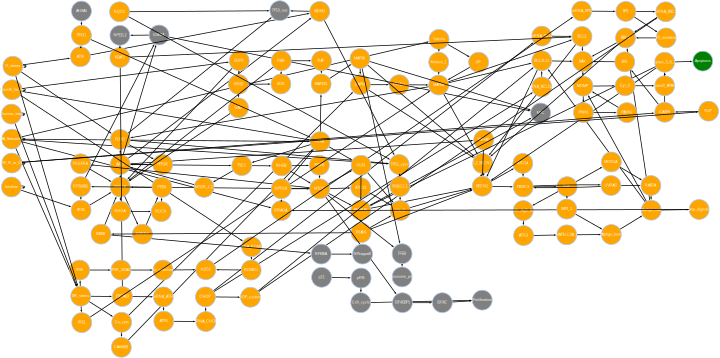

In [26]:
# Extract the subgraph starting from 'cytotoxic'
# Example usage
start_node = 'Apoptosis'
value = 1
upstream_subgraph = extract_upstream_subgraph(DCM, start_node, value)

# Extract label and value from the nodes data where type is 'variable'
node_data = [(data.get('label', 'N/A'), data.get('value', 'N/A')) 
             for node, data in upstream_subgraph.nodes(data=True) if data.get('type') == 'variable']

# Create a dataframe
df_upstream = pd.DataFrame(node_data, columns=['Label', 'Value'])
df_upstream = df_upstream.groupby('Label').mean().sort_values('Value', ascending=False)

pSG = graphviz.Digraph(name='Interaction Graph', engine='neato')
pSG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='scale', splines='false', ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='1.5', color='#aec7e8', style='filled', penwidth='4', fontname='Helvetica', fontcolor='white', fontsize='20')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

# Create a dictionary from df_upstream for quick lookup
node_values = df_upstream['Value'].to_dict()

for nid, d in SG.nodes(data=True):
    nid = str(nid)
    label = d['label']
    pos_graph = str(pos[label][0] / 100) + ',' + str(pos[label][1] / 100)
    
    # Determine fill color based on node value
    if label in node_values:
        value = node_values[label]
        if value == 1:
            fillcolor = 'green'
        elif value == 0.5:
            fillcolor = 'orange'
        else:
            fillcolor = 'blue'
    else:
        fillcolor = 'grey'
    
    pSG.node(nid, label=label, pos=pos_graph, fillcolor=fillcolor)

max_penwidth = 4
for uid, vid, d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight'] * 100)
    pSG.edge(uid, vid, weight=weight)

# Export
display(pSG)
# pSG.render("Thaliana-IG", cleanup=True)

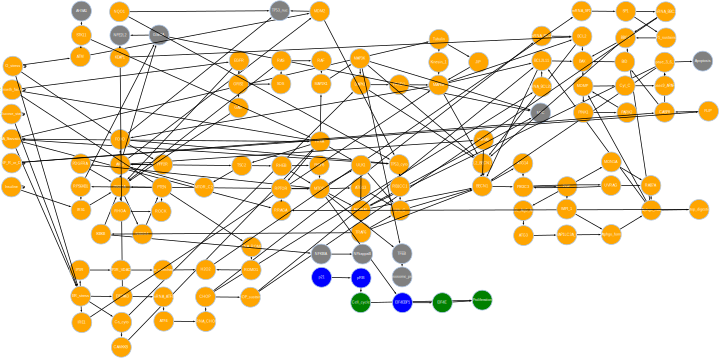

In [27]:
# Extract the subgraph starting from 'cytotoxic'
# Example usage
start_node = 'Proliferation'
value = 1
upstream_subgraph = extract_upstream_subgraph(DCM, start_node, value)

# Extract label and value from the nodes data where type is 'variable'
node_data = [(data.get('label', 'N/A'), data.get('value', 'N/A')) 
             for node, data in upstream_subgraph.nodes(data=True) if data.get('type') == 'variable']

# Create a dataframe
df_upstream = pd.DataFrame(node_data, columns=['Label', 'Value'])
df_upstream = df_upstream.groupby('Label').mean().sort_values('Value', ascending=False)

pSG = graphviz.Digraph(name='Interaction Graph', engine='neato')
pSG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='scale', splines='false', ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='1.5', color='#aec7e8', style='filled', penwidth='4', fontname='Helvetica', fontcolor='white', fontsize='20')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

# Create a dictionary from df_upstream for quick lookup
node_values = df_upstream['Value'].to_dict()

for nid, d in SG.nodes(data=True):
    nid = str(nid)
    label = d['label']
    pos_graph = str(pos[label][0] / 100) + ',' + str(pos[label][1] / 100)
    
    # Determine fill color based on node value
    if label in node_values:
        value = node_values[label]
        if value == 1:
            fillcolor = 'green'
        elif value == 0.5:
            fillcolor = 'orange'
        else:
            fillcolor = 'blue'
    else:
        fillcolor = 'grey'
    
    pSG.node(nid, label=label, pos=pos_graph, fillcolor=fillcolor)

max_penwidth = 4
for uid, vid, d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight'] * 100)
    pSG.edge(uid, vid, weight=weight)

# Export
display(pSG)
# pSG.render("Thaliana-IG", cleanup=True)